## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import fastai
from fastai.utils.mem import *
import os

GPU_NO=0

os.environ["CUDA_VISIBLE_DEVICES"]=str(GPU_NO)
%env CUDA_VISIBLE_DEVICES={GPU_NO}

torch.cuda.set_device(GPU_NO)
torch.cuda.empty_cache()
print(torch.cuda.get_device_name())
print(f"total_memory {torch.cuda.get_device_properties(GPU_NO).total_memory/1024**2}")
print(f"{gpu_mem_get_free_no_cache()}MB of GPU RAM free")

env: CUDA_VISIBLE_DEVICES=0
GeForce RTX 2080 Ti
total_memory 11019.4375
6816MB of GPU RAM free


In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [4]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 52.44 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [5]:
#path = Path('./data/camvid-tiramisu')
path = Path('./SegNet-Tutorial/CamVid')

In [6]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/testannot'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt')]

## Data

In [7]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_07979.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_07971.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08151.png')]

In [8]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_07979.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_07971.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08151.png')]

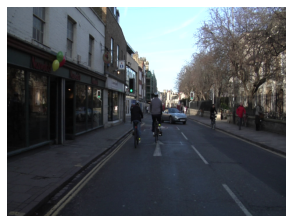

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

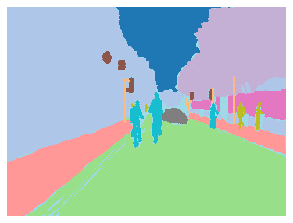

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]),
 tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

## Datasets

In [13]:
bs = 8

In [14]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

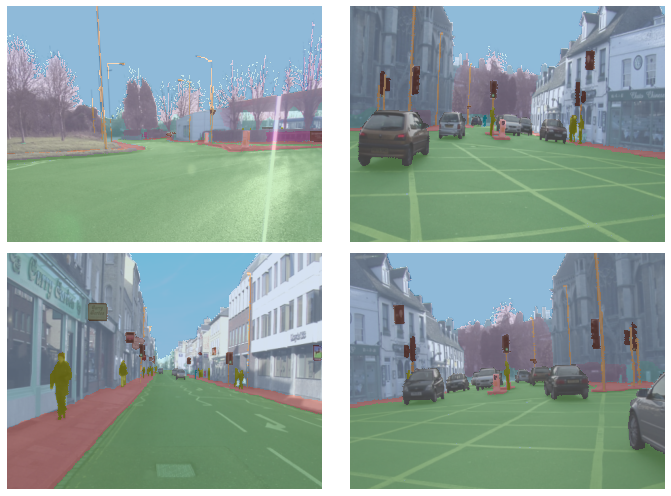

In [16]:
data.show_batch(2, figsize=(10,7))

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


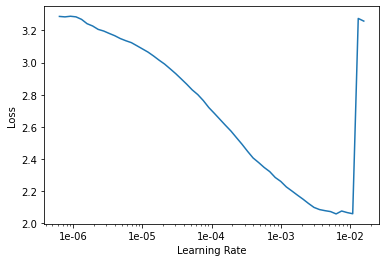

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=2e-3

In [22]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.177112,0.841400,0.766698,00:21
1,0.807723,0.707302,0.821185,00:20
2,0.642396,0.530861,0.858062,00:20
3,0.546234,0.464712,0.868882,00:20
4,0.495297,0.502087,0.861322,00:20
5,0.523225,0.559438,0.842077,00:20
6,1.108149,1.134368,0.663327,00:20
7,0.810880,0.622613,0.835511,00:20
8,0.600644,0.415717,0.873680,00:20
9,0.475445,0.383371,0.879075,00:20


In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

In [25]:
learn.unfreeze()

In [26]:
lrs = slice(lr/100,lr)

In [27]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375671,0.371663,0.879534,00:21
1,0.359830,0.340641,0.892048,00:21
2,0.346358,0.325688,0.903861,00:21
3,0.328999,0.281155,0.919931,00:21
4,0.318527,0.325385,0.900504,00:21
5,0.316524,0.335568,0.893455,00:21
6,0.304534,0.337104,0.900681,00:21
7,0.311924,0.309153,0.914359,00:21
8,0.291963,0.301166,0.916664,00:21
9,0.278127,0.292128,0.913530,00:21


In [28]:
learn.save('stage-2');

## Go big

In [29]:
learn.purge()
gc.collect()

0

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [30]:
size = src_size
bs=8

In [31]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [32]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


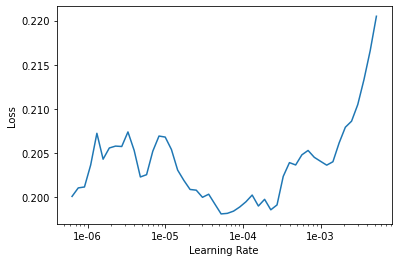

In [33]:
lr_find(learn)
learn.recorder.plot()

In [34]:
lr=1e-3

In [35]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.202888,0.245036,0.928472,00:20
1,0.198586,0.239091,0.932090,00:20
2,0.199288,0.228700,0.935512,00:20
3,0.198878,0.239298,0.933692,00:20
4,0.197408,0.248685,0.926500,00:20
5,0.194877,0.242282,0.930832,00:20
6,0.193539,0.251432,0.932612,00:20
7,0.192856,0.271826,0.925724,00:20
8,0.187640,0.235610,0.932696,00:20
9,0.177044,0.230382,0.936790,00:20


In [36]:
learn.save('stage-1-big')

In [37]:
learn.load('stage-1-big');

In [38]:
learn.unfreeze()

In [39]:
lrs = slice(lr/1000,lr/10)

In [40]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.166229,0.233096,0.935550,00:21
1,0.165106,0.227736,0.936629,00:21
2,0.162353,0.233211,0.935919,00:21
3,0.161448,0.224165,0.938576,00:21
4,0.160282,0.234511,0.936844,00:21
5,0.157908,0.236972,0.935838,00:21
6,0.157944,0.236329,0.936532,00:21
7,0.156009,0.233840,0.937513,00:21
8,0.154672,0.235779,0.936801,00:21
9,0.156127,0.235072,0.936988,00:21


In [41]:
learn.save('stage-2-big')

In [42]:
learn.load('stage-2-big');

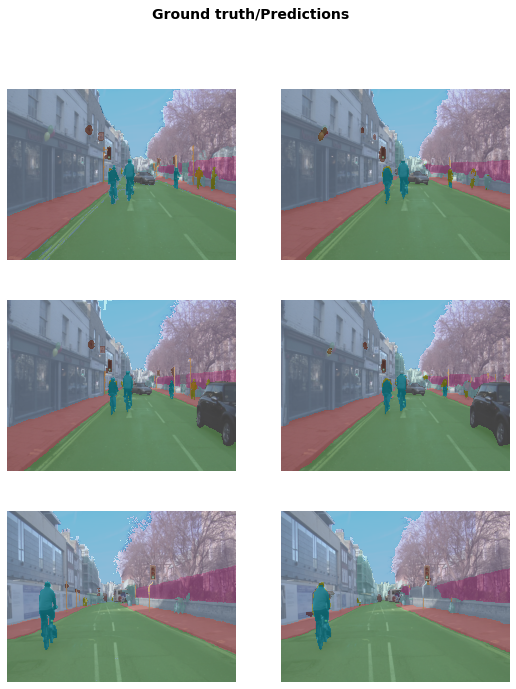

In [43]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [44]:
# start: 480x360

In [45]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________